# Image segmentation using traditonal machine learning

In [1]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Get an example image and its labeled counterpart (ground truth)

(1824, 1824) (1824, 1824)


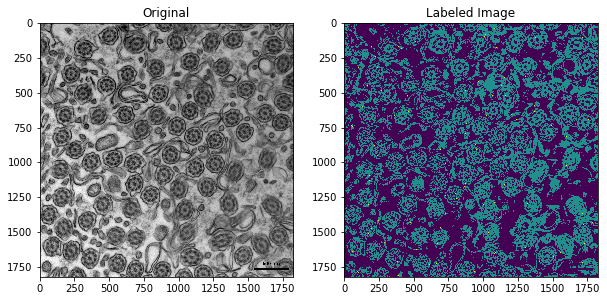

In [2]:
# import the images, both original and ground truth.
img = cv2.imread('images/cilia.jpg')
img_grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
labeled_img = cv2.imread('images/cilia_labeled_hist.jpg')
labeled_img_grayscale = cv2.cvtColor(labeled_img, cv2.COLOR_BGR2GRAY)

fig = plt.figure(figsize=(10,10))
fig.add_subplot(1,2,1)
plt.imshow(img_grayscale, cmap='gray')
plt.title('Original')

fig.add_subplot(1,2,2)
plt.imshow(labeled_img_grayscale) 
plt.title('Labeled Image')

print(img_grayscale.shape, labeled_img_grayscale.shape)

### Step 2: Create feature bank

In [ ]:
#Create the DataFrame and fill it with mutiple filters features

df = pd.DataFrame()
img_col = img_grayscale.reshape(-1)

#ORIGINAL PIXELS
df['Original_pixels'] = img_col

#GABOR FEATURES
#parameters (allow to generate a large set of features)

ksize = 5 #depends on the feature size you want to enhance | Hardcoded here.
phi = 0 #offset | Hardcoded here

gabor_index = 0
gabor_kernels = []

for theta in range(2):
    theta = theta /4. * np.pi
    for sigma in (3,5):
        for lambd in np.arange(0, np.pi, np.pi /4.):
            for gamma in (0.05, 0.5):
                kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, phi, ktype=cv2.CV_32F)
                gabor_kernels.append(kernel)
                filtered_img = cv2.filter2D(img_grayscale, cv2.CV_8UC3, kernel)
                filtered_img_col = filtered_img.reshape(-1)
                df[f'Gabor_{gabor_index}'] = filtered_img_col
                gabor_index += 1
                
#CANNY FEATURES (edge detector)

canny_min = np.arange(50,200,20)
canny_max = np.arange(50,200,20)

for min in canny_min:
    for max in canny_max:
        img_edges = cv2.Canny(img_grayscale, min, max)
        img_edges_col = img_edges.reshape(-1)
        df[f'Canny_{min}_{max}'] = img_edges_col

#ROBERTS, SOBEL, SCHARR, PREWITT FEATURES

from skimage.filters import roberts, sobel, scharr, prewitt

img_roberts = roberts(img_grayscale)
df['Roberts'] = img_roberts.reshape(-1)

img_sobel = sobel(img_grayscale)
df['Sobel'] = img_sobel.reshape(-1)

img_scharr = scharr(img_grayscale)
df['Scharr'] = img_scharr.reshape(-1)

img_prewitt = prewitt(img_grayscale)
df['Prewitt'] = img_prewitt.reshape(-1)

#GAUSSIAN

from scipy import ndimage as nd

for gauss_sigma in np.arange(1,20,2):
    gaussian_img = nd.gaussian_filter(img_grayscale, gauss_sigma)
    df[f'Gaussian_{gauss_sigma}'] = gaussian_img.reshape(-1)
    
#VARIANCE (SLOW !)

#for variance_size in np.arange(1,5,1):
#    variance_img = nd.generic_filter(img_grayscale, np.var, size=variance_size)
#    df[f'Variance_{variance_size}'] = variance_img.reshape(-1)
    
    
#MEDIAN

for median_size in np.arange(1,10,2):
    median_img = nd.median_filter(img_grayscale, size=median_size)
    df[f'Median_{median_size}'] = median_img.reshape(-1)
        
#Print the feature stack to see how it looks like                
df.head(20)

In [ ]:
#add labels
df['Labels'] = labeled_img_grayscale.reshape(-1)

df.head(20)

### Step 3: Create the model and validate it

### Step 4: Find which features are relevant

### Step 5: Save the model as pickle

### Step 6: Use the model for segmentation